In [1]:
from pathlib import Path
from Bio.PDB import PDBList, PDBParser
import os
from tqdm import tqdm
import warnings
import pandas as pd
from Bio import SeqIO
from dotenv import load_dotenv
import os
import requests
import time
import json
from Bio.PDB.ic_rebuild import structure_rebuild_test
import numpy as np
import sys
import seaborn as sns
from Bio.Align import PairwiseAligner
import matplotlib.pyplot as plt

load_dotenv()

True

In [2]:
WINDOW_SIZE = 3
PDBMINE_URL = os.getenv("PDBMINE_URL")
casp_protein_id = 'T1024'
casp_protein_id2 = 'T1024'
pdb_code = '6t1z'
alphafold_id = f'{casp_protein_id}TS427_1'
outdir = Path(f'csvs/{casp_protein_id}')
# outdir.mkdir(exist_ok=False, parents=True)

In [3]:
amino_acid_codes = {
    "ALA": "A",
    "ARG": "R",
    "ASN": "N",
    "ASP": "D",
    "CYS": "C",
    "GLN": "Q",
    "GLU": "E",
    "GLY": "G",
    "HIS": "H",
    "ILE": "I",
    "LEU": "L",
    "LYS": "K",
    "MET": "M",
    "PHE": "F",
    "PRO": "P",
    "SER": "S",
    "THR": "T",
    "TRP": "W",
    "TYR": "Y",
    "VAL": "V"
}

In [4]:
# Get X-ray pdb
pdbl = PDBList()
parser = PDBParser()
xray_fn = pdbl.retrieve_pdb_file(pdb_code, pdir='pdb', file_format='pdb', obsolete=False)
# Get X-ray structure
# xray_url = 'https://predictioncenter.org/download_area/CASP14/targets/casp14.targets.T.public_11.29.2020.tar.gz'
# xray_dir = Path('./casp-xray')
# xray_dir.mkdir(exist_ok=True)
# os.system(f'wget -O {xray_dir}/casp14.targets.T.public_11.29.2020.tar.gz {xray_url}')
# os.system(f'tar -xvf {xray_dir}/casp14.targets.T.public_11.29.2020.tar.gz -C {xray_dir}')
# xray_fn = xray_dir / f'{casp_protein_id}.pdb'
# xray_url = "https://predictioncenter.org/casp14/target.cgi?target=T1024&view=template"
# xray_fn = Path(f'./casp-xray/{casp_protein_id}.pdb')

# Get CASP predictions
predictions_url = f'https://predictioncenter.org/download_area/CASP14/predictions/regular/{casp_protein_id}.tar.gz'
predictions_dir = Path(f'./casp-predictions/')
if not (predictions_dir / casp_protein_id).exists():
    predictions_dir.mkdir(exist_ok=True)
    os.system(f'wget -O {predictions_dir}/{casp_protein_id}.tar.gz {predictions_url}')
    os.system(f'tar -xvf {predictions_dir}/{casp_protein_id}.tar.gz -C {predictions_dir}')

# Get CASP results
results_url = 'https://predictioncenter.org/download_area/CASP14/results/tables/casp14.res_tables.T.tar.gz'
results_dir = Path('casp-results')
if not results_dir.exists():
    results_dir.mkdir(exist_ok=True)
    os.system(f'wget -O {results_dir / "casp14.res_tables.T.tar.gz"} {results_url}')
    os.system(f'tar -xvf {results_dir / "casp14.res_tables.T.tar.gz"} -C {results_dir}')
results_file = results_dir / f'{casp_protein_id2}.txt'
results = pd.read_csv(results_file, delim_whitespace=True)
results = results[results.columns[1:]]

Structure exists: 'pdb/pdb6t1z.ent' 


/tmp/ipykernel_1104249/2620931729.py:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  results = pd.read_csv(results_file, delim_whitespace=True)


In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    record = next(iter(SeqIO.parse(xray_fn, "pdb-seqres")))
    print("Record id %s, chain %s" % (record.id, record.annotations["chain"]))
    # print(record.seq)
    print(len(record.seq))
    residue_chain = str(record.seq)#[residue_range[0]-1:residue_range[1]]
    print(residue_chain)

    pred_files = list((predictions_dir / casp_protein_id).iterdir())
    i=0
    print(pred_files[i].name)
    pred_seq = str(next(iter(SeqIO.parse(pred_files[i], "pdb-atom"))).seq)
    print(pred_seq)

    aligner = PairwiseAligner()
    aligner.mode = 'global'
    alignments =  aligner.align(residue_chain, pred_seq)

    print(alignments[0])
    print('Large matches:')
    for i,((t1,t2),(q1,q2)) in enumerate(zip(*alignments[0].aligned)):
        if t2-t1 > 5:
            print(f'Match of length: {t2-t1} residues at position t={t1}, q={q1}')

Record id 6T1Z:A, chain A
411
GKEFWNLDKNLQLRLGIVFLGAFSYGTVFSSMTIYYNQYLGSAITGILLALSAVATFVAGILAGFFADRNGRKPVMVFGTIIQLLGAALAIASNLPGHVNPWSTFIAFLLISFGYNFVITAGNAMIIDASNAENRKVVFMLDYWAQNLSVILGAALGAWLFRPAFEALLVILLLTVLVSFFLTTFVMTETFKPTVKVDNIFQAYKTVLQDKTYMIFMGANIATTFIIMQFDNFLPVHLSNSFKTITFWGFEIYGQRMLTIYLILACVLVVLLMTTLNRLTKDWSHQKGFIWGSLFMAIGMIFSFLTTTFTPIFIAGIVYTLGEIVYTPSVQTLGADLMNPEKIGSYNGVAAIKMPIASILAGLLVSISPMIKAIGVSLVLALTEVLAIILVLVAVNRHQKTKLNLEVLFQG
T1024TS081_3
MKEFWNLDKNLQLRLGIVFLGAFSYGTVFSSMTIYYNQYLGSAITGILLALSAVATFVAGILAGFFADRNGRKPVMVFGTIIQLLGAALAIASNLPGHVNPWSTFIAFLLISFGYNFVITAGNAMIIDASNAENRKVVFMLDYWAQNLSVILGAALGAWLFRPAFEALLVILLLTVLVSFFLTTFVMTETFKPTVKVDEKAENIFQAYKTVLQDKTYMIFMGANIATTFIIMQFDNFLPVHLSNSFKTITFWGFEIYGQRMLTIYLILACVLVVLLMTTLNRLTKDWSHQKGFIWGSLFMAIGMIFSFLTTTFTPIFIAGIVYTLGEIVYTPSVQTLGADLMNPEKIGSYNGVAAIKMPIASILAGLLVSISPMIKAIGVSLVLALTEVLAIILVLVAVNRHQKTKLN
target            0 G-KEFWNLDKNLQLRLGIVFLGAFSYGTVFSSMTIYYNQYLGSAITGILLALSAVATFVA
                  0 --|||||||||||||||||||||||||||||||||

In [6]:
# Get structures
xray = parser.get_structure(pdb_code, xray_fn)

predicted_structures = []
for prediction_pdb in tqdm((predictions_dir / casp_protein_id).iterdir()):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        predicted_structures.append(parser.get_structure(prediction_pdb.name, prediction_pdb))

0it [00:00, ?it/s]

512it [00:14, 34.68it/s]


# PDBMine

In [7]:
response = requests.get(PDBMINE_URL + f'/v1/api/protein/{pdb_code}', verify=False)
assert(response.ok)
protein_data = response.json()

In [18]:
response = requests.post(
    PDBMINE_URL + f'/v1/api/query',
    json={
        "residueChain": 'DVES',
        "codeLength": 1,
        "windowSize": 4
    }
)
query_id = response.json().get('queryID')

In [19]:
requests.get(PDBMINE_URL + f'/v1/api/query/{query_id}').json()['frames']

{'000_DVES': {'1A0R_P': [[{'residueName': 'D', 'phi': -68.3, 'psi': -45.6},
    {'residueName': 'V', 'phi': -63.9, 'psi': -38.6},
    {'residueName': 'E', 'phi': -57.3, 'psi': -53.6},
    {'residueName': 'S', 'phi': -57.8, 'psi': -47.6}]],
  '1A26_A': [[{'residueName': 'D', 'phi': -63.5, 'psi': 119.3},
    {'residueName': 'V', 'phi': -68.4, 'psi': -33.1},
    {'residueName': 'E', 'phi': -68.8, 'psi': -33.5},
    {'residueName': 'S', 'phi': -69.6, 'psi': -36.2}]],
  '1A39_A': [[{'residueName': 'D', 'phi': -152.4, 'psi': 172.2},
    {'residueName': 'V', 'phi': -60.8, 'psi': -51.2},
    {'residueName': 'E', 'phi': -55.2, 'psi': -46.9},
    {'residueName': 'S', 'phi': -64.6, 'psi': -44.4}]],
  '1B5T_A': [[{'residueName': 'D', 'phi': -110.7, 'psi': 105.6},
    {'residueName': 'V', 'phi': -60.6, 'psi': -28.2},
    {'residueName': 'E', 'phi': -59.8, 'psi': -36.9},
    {'residueName': 'S', 'phi': -59.6, 'psi': -45.3}]],
  '1B5T_B': [[{'residueName': 'D', 'phi': -106.7, 'psi': 101},
    {'resid

In [8]:
# Get Phi-Psi distribution from PDBMine
record = next(iter(SeqIO.parse(xray_fn, "pdb-seqres")))
residue_chain = str(record.seq)
code_length = 1
broken_chains = []
# break into sections of length 100
for i in range(0, len(residue_chain), 100-WINDOW_SIZE+1):
    broken_chains.append(residue_chain[i:i+100])

matches = {}
for chain in tqdm(broken_chains):
    if len(chain) < WINDOW_SIZE:
        continue
    response = requests.post(
        PDBMINE_URL + '/v1/api/query',
        json={
            "residueChain": chain,
            "codeLength": code_length,
            "windowSize": WINDOW_SIZE
        }
    )
    assert(response.ok)
    print(response.json())
    query_id = response.json().get('queryID')
    assert(query_id)

    time.sleep(30)
    while(True):
        response = requests.get(PDBMINE_URL + f'/v1/api/query/{query_id}')
        if response.ok:
            matchesi = response.json()['frames']
            break
        else:
            print('Waiting')
            time.sleep(15)
    print('Received matches')
    matches.update(matchesi)
json.dump(matches, open(outdir / 'matches.json', 'w'), indent=4)

  0%|          | 0/5 [00:00<?, ?it/s]

{'status': 'Running', 'queryID': '68d705cc-0728-11ef-8a9b-0242ac110002'}


  0%|          | 0/5 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
matches = json.load(open(outdir / 'matches.json'))

In [36]:
len(list(matches.keys()))

220

In [38]:
# Get phi-psi by window
# If any sequence appears twice, only take the first one bc the distribution is the same
seqs = []
phi_psi_mined_by_window_ = []
for seq_win,v in matches.items():
    seq = seq_win[4:]
    if seq in seqs:
        continue
    seqs.append(seq)
    for protein,seq_matches in v.items():
        protein_id, chain = protein.split('_')
        if protein_id.lower() == pdb_code.lower(): # skip the protein we're looking at
            continue
        for seq_match in seq_matches:
            center_res = seq_match[WINDOW_SIZE//2]
            res, phi, psi = center_res.values()
            phi_psi_mined_by_window_.append([seq, res, phi, psi, chain, protein_id])

phi_psi_mined = pd.DataFrame(phi_psi_mined_by_window_, columns=['seq', 'res', 'phi', 'psi', 'chain', 'protein_id'])
phi_psi_mined.to_csv(outdir / 'phi_psi_mined.csv', index=False)

In [39]:
phi_psi_mined = pd.read_csv(outdir / 'phi_psi_mined.csv')

# Collect Dihedrals - Xray and predictions

In [91]:
xray_structure = parser.get_structure(pdb_code, xray_fn)
xray_chain = list(xray_structure[0].get_chains())[0]

def get_phi_psi_for_structure(protein_structure, protein_id):
    protein_structure.atom_to_internal_coordinates(verbose=False)
    resultDict = structure_rebuild_test(protein_structure)
    if not resultDict['pass']:
        raise Exception('Failed to rebuild')
    residues = list(protein_structure.get_residues())
    phi_psi_ = []
    for i in range(WINDOW_SIZE//2, len(residues) - WINDOW_SIZE // 2):
        # Convert 3 char codes to 1 char codes
        seq = ''.join([amino_acid_codes.get(r.resname, 'X') for r in residues[i-WINDOW_SIZE//2:i+WINDOW_SIZE//2+1]])
        # Get the center residue
        res = seq[-WINDOW_SIZE//2]
        if not residues[i].internal_coord:
            psi,phi = np.nan, np.nan
        else:
            psi = residues[i].internal_coord.get_angle("psi")
            phi = residues[i].internal_coord.get_angle("phi")
            psi = psi if psi else np.nan # if psi is None, set it to np.nan
            phi = phi if phi else np.nan # if phi is None, set it to np.nan
        phi_psi_.append([i, seq, res, phi, psi, xray_chain.id, protein_id])
    return phi_psi_

xray_phi_psi = get_phi_psi_for_structure(xray_chain, pdb_code)
xray_phi_psi = pd.DataFrame(xray_phi_psi, columns=['pos', 'seq', 'res', 'phi', 'psi', 'chain', 'protein_id'])
xray_phi_psi.to_csv(outdir / 'xray_phi_psi.csv', index=False)

In [92]:
# Get phi_psi's of each prediction
phi_psi_predictions_ = []
for prediction in tqdm(predicted_structures):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            chain = list(prediction[0].get_chains())[0]
            phi_psi_predictions_ += get_phi_psi_for_structure(chain, prediction.id)
        except Exception as e:
            print(e)
phi_psi_predictions = pd.DataFrame(phi_psi_predictions_, columns=['pos', 'seq', 'res', 'phi', 'psi', 'chain', 'protein_id'])
phi_psi_predictions.to_csv(outdir / 'phi_psi_predictions.csv', index=False)

 15%|█▍        | 76/512 [01:22<08:07,  1.12s/it] 

Failed to rebuild


 19%|█▉        | 97/512 [01:36<03:37,  1.91it/s]

Failed to rebuild


 20%|██        | 103/512 [01:39<03:18,  2.06it/s]

Failed to rebuild


 23%|██▎       | 119/512 [01:52<02:44,  2.38it/s]

Failed to rebuild


 25%|██▌       | 129/512 [02:02<03:58,  1.61it/s]

Failed to rebuild


 26%|██▌       | 131/512 [02:03<03:25,  1.85it/s]

Failed to rebuild


 29%|██▉       | 150/512 [02:18<03:10,  1.90it/s]

Failed to rebuild


 30%|██▉       | 152/512 [02:19<02:57,  2.03it/s]

Failed to rebuild


 32%|███▏      | 164/512 [02:31<06:42,  1.16s/it]

Failed to rebuild


 34%|███▍      | 173/512 [02:35<02:35,  2.18it/s]

Failed to rebuild


 34%|███▍      | 174/512 [02:36<02:34,  2.18it/s]

Failed to rebuild


 37%|███▋      | 188/512 [02:50<06:45,  1.25s/it]

Failed to rebuild


 47%|████▋     | 239/512 [03:30<10:33,  2.32s/it]

Failed to rebuild


 58%|█████▊    | 296/512 [04:06<01:35,  2.27it/s]

Failed to rebuild


 58%|█████▊    | 299/512 [04:07<01:30,  2.35it/s]

Failed to rebuild


 60%|█████▉    | 307/512 [04:22<04:07,  1.21s/it]

Failed to rebuild


 61%|██████    | 312/512 [04:24<02:03,  1.62it/s]

Failed to rebuild


 62%|██████▏   | 319/512 [04:28<01:34,  2.05it/s]

Failed to rebuild


 68%|██████▊   | 350/512 [04:53<01:31,  1.77it/s]

Failed to rebuild


 82%|████████▏ | 420/512 [05:36<00:39,  2.36it/s]

Failed to rebuild


 83%|████████▎ | 425/512 [05:38<00:37,  2.32it/s]

Failed to rebuild


 85%|████████▌ | 436/512 [05:56<00:51,  1.49it/s]

Failed to rebuild


 87%|████████▋ | 445/512 [06:00<00:29,  2.28it/s]

Failed to rebuild


 93%|█████████▎| 474/512 [06:13<00:15,  2.38it/s]

Failed to rebuild


 96%|█████████▌| 491/512 [06:35<00:10,  1.98it/s]

Failed to rebuild


 98%|█████████▊| 503/512 [06:41<00:04,  2.21it/s]

Failed to rebuild


 99%|█████████▉| 508/512 [06:43<00:01,  2.14it/s]

Failed to rebuild


 99%|█████████▉| 509/512 [06:44<00:01,  2.27it/s]

Failed to rebuild


100%|██████████| 512/512 [06:45<00:00,  1.26it/s]


# Compute RMSD of predictions

In [ ]:
# pred_files = list((predictions_dir / casp_protein_id).iterdir())
# i=0
# print(pred_files[i].name)
# pred_seq = str(next(iter(SeqIO.parse(pred_files[i], "pdb-atom"))).seq)
# print(pred_seq)

# from Bio.Align import PairwiseAligner
# aligner = PairwiseAligner()
# aligner.mode = 'global'
# alignments =  aligner.align(residue_chain, pred_seq)

# print(alignments[0].aligned)
# largest_alignment = -1
# for i,((t1,t2),(q1,q2)) in enumerate(zip(*alignments[0].aligned)):
#     print(t1,t2,q1,q2)

#     # print(residue_chain[t1:t2])
#     # print(pred_seq[q1:q2])

In [ ]:
# from Bio.PDB import Superimposer

# def get_rmsd(model1, model2):
#     atoms1 = []
#     atoms2 = []
#     for chain1, chain2 in zip(model1.get_chains(), model2.get_chains()):
#         for residue1, residue2 in zip(chain1, chain2):
#             if residue1.resname != residue2.resname:
#                 raise ValueError('Residues are not aligned')
#             for atom1 in residue1:
#                 if atom1.get_id() in ['CA']:
#                 # if atom1.get_id() in ['N', 'CA', 'C']:
#                     atom2 = residue2[atom1.get_id()]
#                     if atom2 is None:
#                         raise ValueError('Atoms are not aligned')
#                     atoms1.append(atom1)
#                     atoms2.append(atom2)
#     atoms1, atoms2 = np.array(atoms1), np.array(atoms2)

#     sup = Superimposer()
#     sup.set_atoms(atoms1, atoms2)
#     sup.apply(atoms2) # align with SVD (PDB.SVDSuperimposer)

#     return sup.rms

# rmsds_ = []
# for prediction in tqdm(predicted_structures):
#     rmsds_.append([prediction.id, get_rmsd(xray, prediction)])

# rmsds = pd.DataFrame(rmsds_, columns=['protein_id', 'rmsd'])

# Results - By Window

In [103]:
import pandas as pd
phi_psi_mined = pd.read_csv(outdir / 'phi_psi_mined.csv')
phi_psi_predictions = pd.read_csv(outdir / 'phi_psi_predictions.csv')
xray_phi_psi = pd.read_csv(outdir / 'xray_phi_psi.csv')
phi_psi_mined['source'] = 'Query (PDBMine)'
phi_psi_predictions['source'] = 'Prediction'
xray_phi_psi['source'] = 'X-ray'
overlapping_seqs = list(set(phi_psi_mined.seq) & set(phi_psi_predictions.seq) & set(xray_phi_psi.seq))

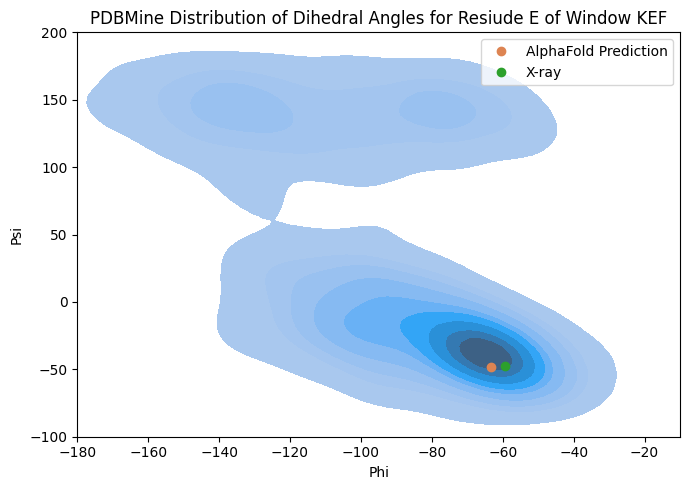

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_one_dist(seq, pred_id, pred_name=None, axlims=None):
    pred_name = pred_name or pred_id
    phi_psi_dist = phi_psi_mined[phi_psi_mined.seq == seq]
    phi_psi_alpha = phi_psi_predictions[(phi_psi_predictions.protein_id == alphafold_id) & (phi_psi_predictions.seq == seq)]
    xray_phi_psi_seq = xray_phi_psi[xray_phi_psi.seq == seq]

    fig, ax = plt.subplots(figsize=(7,5))
    sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax, fill=True)
    ax.plot(phi_psi_alpha.phi, phi_psi_alpha.psi, 'o', color='#dd8452', label='AlphaFold Prediction')
    ax.plot(xray_phi_psi_seq.phi, xray_phi_psi_seq.psi, 'o', color='tab:green', label='X-ray')
    ax.legend()
    ax.set_title(f'PDBMine Distribution of Dihedral Angles for Resiude E of Window KEF')

    ax.set_xlabel('Phi')
    ax.set_ylabel('Psi')

    if axlims:
        ax.set_xlim(axlims[0][0], axlims[0][1])
        ax.set_ylim(axlims[1][0], axlims[1][1])

    plt.tight_layout()

seq = overlapping_seqs[0]
plot_one_dist(seq, alphafold_id, 'AlphaFold', axlims=((-180, -10), (-100, 200)))

# Mahalanobis

xray: 2.0608394855153387
alpha: 2.1775324915205747
preds:
                 0
count  479.000000
mean     2.488303
std      1.172720
min      0.191551
25%      2.288022
50%      2.360408
75%      2.454738
max     13.552795


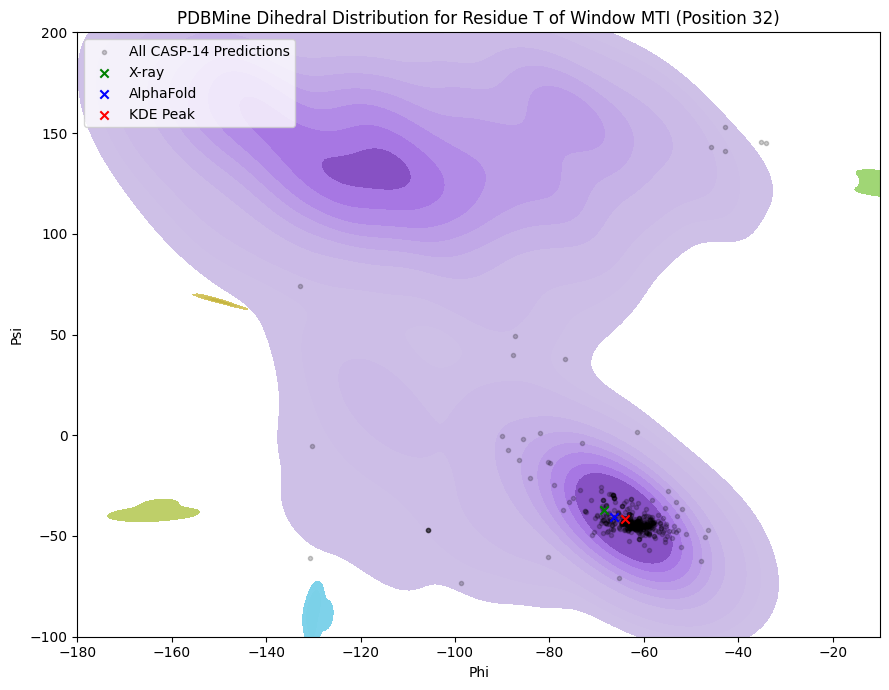

In [129]:
# For one window
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_clusters_for_window(seq, pred_id, pred_name=None, eps=10, axlims=None, zoom=False, zoom_lims=None):
    pred_name = pred_name or pred_id
    phi_psi_dist = phi_psi_mined.loc[phi_psi_mined.seq == seq][['phi','psi']]

    # Find clusters
    clustering = DBSCAN(eps=eps, min_samples=3).fit(phi_psi_dist.values)
    phi_psi_dist['cluster'] = clustering.labels_

    # Find most probable data point and the cluster it belongs to
    kernel = gaussian_kde(phi_psi_dist[['phi','psi']].T)
    phi_psi_most_likely_idx = kernel(phi_psi_dist[['phi','psi']].T).argmax()
    phi_psi_c = phi_psi_dist.loc[phi_psi_dist.cluster == phi_psi_dist.iloc[phi_psi_most_likely_idx].cluster, ['phi','psi']].values

    # Mahalanobis distance to most common cluster
    cov = np.cov(phi_psi_c.T)
    icov = np.linalg.inv(cov)

    # xray
    xray = xray_phi_psi[xray_phi_psi.seq == seq][['phi','psi']].values
    pos = xray_phi_psi[xray_phi_psi.seq == seq]['pos'].values[0]
    md_xray = (xray - phi_psi_c.mean(axis=0)) @ icov @ (xray - phi_psi_c.mean(axis=0)).T

    # alphafold to most common cluster
    alpha = phi_psi_predictions[(phi_psi_predictions.protein_id == alphafold_id) & (phi_psi_predictions.seq == seq)][['phi','psi']].values
    md_alpha = (alpha - phi_psi_c.mean(axis=0)) @ icov @ (alpha - phi_psi_c.mean(axis=0)).T

    # Other predictions
    preds = phi_psi_predictions[phi_psi_predictions.seq == seq][['phi','psi']].values
    icov = np.repeat(np.expand_dims(icov, 0), preds.shape[0], axis=0) # expand for batch matrix multiplication
    md_preds = (np.expand_dims((preds - phi_psi_c.mean(axis=0)), 1) @ icov @ np.expand_dims((preds - phi_psi_c.mean(axis=0)), 2)).squeeze()
    print('xray:', md_xray[0,0])
    print('alpha:', md_alpha[0,0])
    print('preds:\n', pd.DataFrame(md_preds).describe())

    if not zoom:
        fig, ax = plt.subplots(figsize=(9,7))
        sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', hue='cluster', palette='viridis', ax=ax, fill=True, legend=False)
        ax.scatter(preds[:,0], preds[:,1], color='black', marker='.', alpha=0.2, label='All CASP-14 Predictions')
        ax.scatter(xray[0,0], xray[0,1], color='green', marker='x', label='X-ray')
        ax.scatter(alpha[0,0], alpha[0,1], color='blue', marker='x', label='AlphaFold')
        ax.scatter(phi_psi_dist.iloc[phi_psi_most_likely_idx].phi, phi_psi_dist.iloc[phi_psi_most_likely_idx].psi, color='red', marker='x', label='KDE Peak')
        ax.set_xlabel('Phi')
        ax.set_ylabel('Psi')
        ax.set_title(f'PDBMine Dihedral Distribution for Residue {seq[-WINDOW_SIZE//2]} of Window {seq} (Position {pos})')
        ax.legend()
        if axlims:
            ax.set_xlim(axlims[0][0], axlims[0][1])
            ax.set_ylim(axlims[1][0], axlims[1][1])
        plt.tight_layout()
    else:
        # Zoomed in
        fig, ax = plt.subplots(figsize=(7,5))
        sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', hue='cluster', palette='viridis', ax=ax, fill=True, legend=False)
        ax.scatter(preds[:,0], preds[:,1], color='black', marker='.', alpha=0.2, label='All CASP-14 Predictions')
        ax.scatter(xray[0,0], xray[0,1], color='green', marker='x', s=100, label='X-ray')
        ax.scatter(alpha[0,0], alpha[0,1], color='blue', marker='x', s=100, label='AlphaFold')
        ax.scatter(phi_psi_dist.iloc[phi_psi_most_likely_idx].phi, phi_psi_dist.iloc[phi_psi_most_likely_idx].psi, color='red', marker='x', s=100, label='KDE Peak')
        ax.set_xlim(zoom_lims[0][0], zoom_lims[0][1])
        ax.set_ylim(zoom_lims[1][0], zoom_lims[1][1])
        ax.axis('off')
        plt.tight_layout()
seq = overlapping_seqs[164]
plot_clusters_for_window(seq, alphafold_id, 'AlphaFold', eps=10, axlims=((-180, -10), (-100, 200)))
# plot_clusters_for_window(seq, alphafold_id, 'AlphaFold', eps=10, zoom=True, zoom_lims=((-180, -10), (-100, 200)))

In [ ]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def get_md_for_all_predictions(phi_psi_predictions, xray_phi_psi, eps=10):
    mds = []
    phi_psi_predictions['md'] = np.nan
    xray_phi_psi['md'] = np.nan
    for i,seq in tqdm(enumerate(phi_psi_mined.seq.unique())):
        phi_psi_dist = phi_psi_mined.loc[phi_psi_mined.seq == seq][['phi','psi']]
        xray = xray_phi_psi[xray_phi_psi.seq == seq][['phi','psi']].values
        preds = phi_psi_predictions.loc[phi_psi_predictions.seq == seq][['phi','psi']].values

        if phi_psi_dist.shape[0] < 2 or xray.shape[0] < 1 or preds.shape[0] < 1:
            print(f'Skipping {seq} - not enough data points')
            xray_phi_psi.loc[xray_phi_psi.seq == seq, 'md'] = np.nan
            phi_psi_predictions.loc[phi_psi_predictions.seq == seq, 'md'] = np.nan        
            continue
        # Find clusters
        clustering = DBSCAN(eps=eps, min_samples=3).fit(phi_psi_dist.values)
        phi_psi_dist['cluster'] = clustering.labels_

        # Find most probable data point and the cluster it belongs to
        kernel = gaussian_kde(phi_psi_dist[['phi','psi']].T)
        phi_psi_most_likely_idx = kernel(phi_psi_dist[['phi','psi']].T).argmax()
        phi_psi_c = phi_psi_dist.loc[phi_psi_dist.cluster == phi_psi_dist.iloc[phi_psi_most_likely_idx].cluster, ['phi','psi']].values

        # Mahalanobis distance to most common cluster
        cov = np.cov(phi_psi_c.T)
        if np.linalg.det(cov) == 0:
            print(f'Skipping {seq} - singular matrix')
            xray_phi_psi.loc[xray_phi_psi.seq == seq, 'md'] = np.nan
            phi_psi_predictions.loc[phi_psi_predictions.seq == seq, 'md'] = np.nan
            continue
        icov = np.linalg.inv(cov)

        # xray
        md_xray = (xray - phi_psi_c.mean(axis=0)) @ icov @ (xray - phi_psi_c.mean(axis=0)).T
        if np.any(md_xray < 0):
            md_xray = np.nan
        else:
            md_xray = np.sqrt(md_xray)[0,0]
        xray_phi_psi.loc[xray_phi_psi.seq == seq, 'md'] = md_xray

        # All predictions
        mean = phi_psi_dist[['phi','psi']].mean(axis=0).values
        md = (np.expand_dims((preds - mean), 1) @ icov @ np.expand_dims((preds - mean), 2)).squeeze()
        if np.any(md < 0):
            md = np.nan
        else:
            md = np.sqrt(md)
        phi_psi_predictions.loc[phi_psi_predictions.seq == seq, 'md'] = md

eps=10
get_md_for_all_predictions(phi_psi_predictions, xray_phi_psi, eps)
phi_psi_predictions.to_csv(outdir / f'phi_psi_predictions_md-eps{eps}.csv', index=False)
xray_phi_psi.to_csv(outdir / f'xray_phi_psi_md-eps{eps}.csv', index=False)

In [87]:
eps=1.5
phi_psi_predictions = pd.read_csv(outdir / f'phi_psi_predictions_md-eps{eps}.csv')
xray_phi_psi = pd.read_csv(outdir / f'xray_phi_psi_md-eps{eps}.csv')

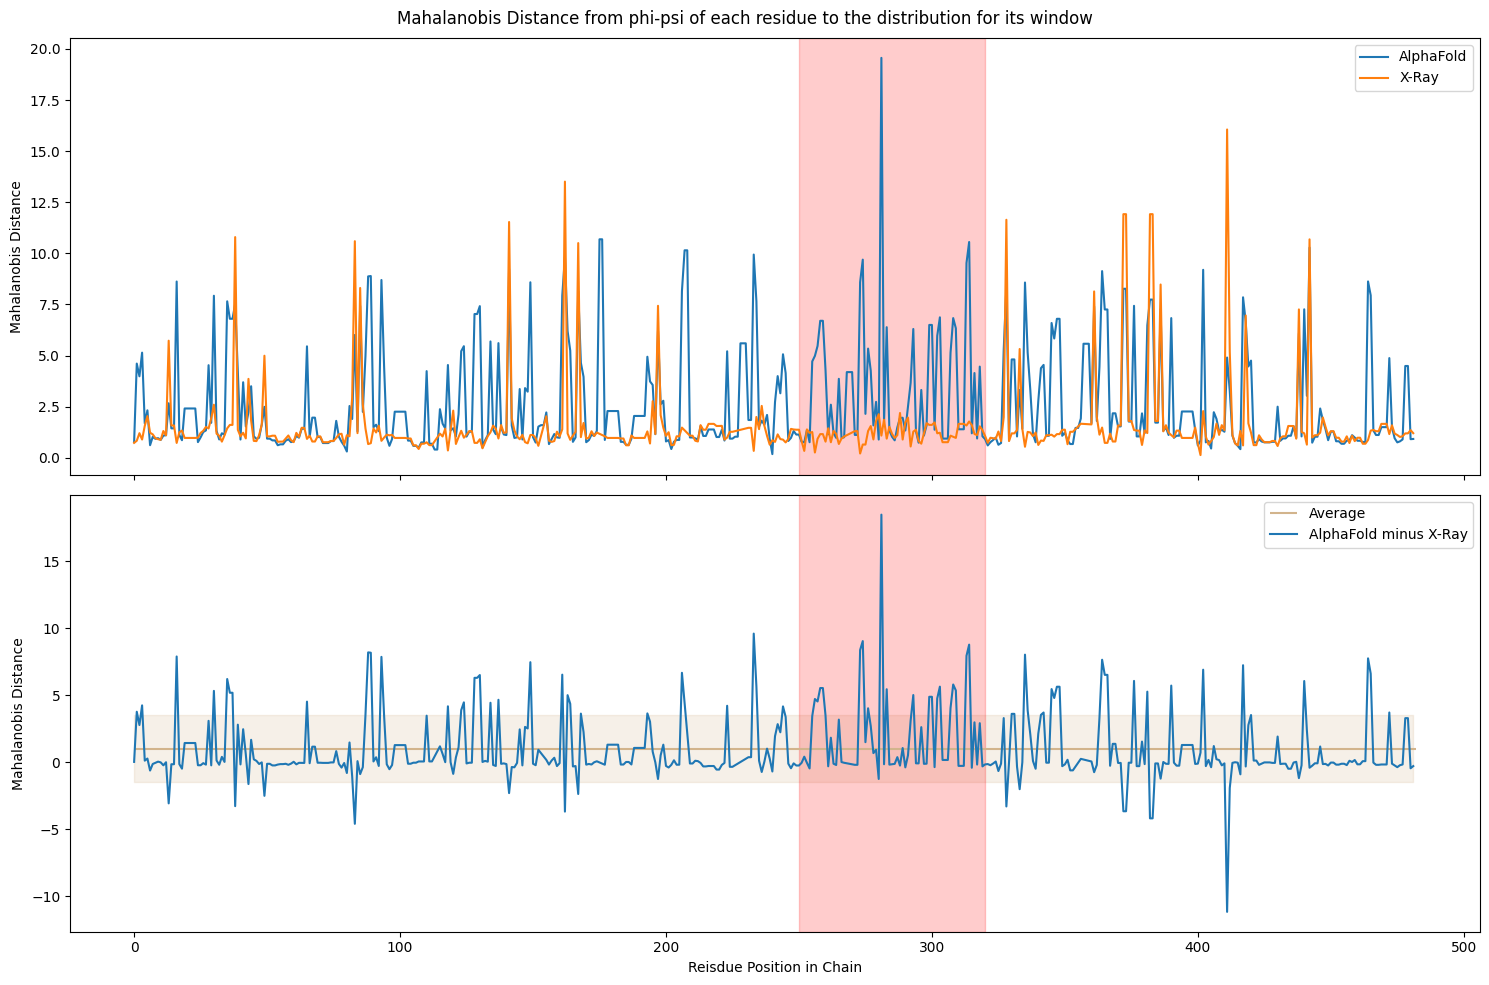

In [88]:
# Plot xray vs prediction md for each residue of one prediction
def plot_res_vs_md(pred_id, pred_name=None, highlight_res=None):
    pred_name = pred_name or pred_id
    phi_psi_predictions['Source'] = 'CASP Prediction'
    phi_psi_predictions.loc[phi_psi_predictions.protein_id == pred_id, 'Source'] = pred_name
    alpha = phi_psi_predictions.loc[phi_psi_predictions.protein_id == pred_id]
    xray_phi_psi['Source'] = 'X-Ray'
    both = pd.merge(alpha, xray_phi_psi, how='inner', on=['seq','seq'], suffixes=('_alpha','_xray'))
    both['md_diff'] = both['md_alpha'] - both['md_xray']
    fig, axes = plt.subplots(2, figsize=(15,10), sharex=True)
    sns.lineplot(data=both.reset_index(), x='index', y='md_alpha', ax=axes[0], label=pred_name)
    sns.lineplot(data=both.reset_index(), x='index', y='md_xray', ax=axes[0], label='X-Ray')
    axes[0].set_ylabel('Mahalanobis Distance')
    axes[1].hlines(both['md_diff'].mean(), xmin=0, xmax=len(both), color='tan', label='Average')
    axes[1].fill_between(x=both.index, y1=both['md_diff'].mean() + both['md_diff'].std(), y2=both['md_diff'].mean() - both['md_diff'].std(), color='tan', alpha=0.2)
    sns.lineplot(data=both.reset_index(), x='index', y='md_diff', ax=axes[1], label=f'{pred_name} minus X-Ray')
    axes[1].set_ylabel('Mahalanobis Distance')
    axes[1].set_xlabel('Reisdue Position in Chain')
    fig.suptitle('Mahalanobis Distance from phi-psi of each residue to the distribution for its window')
    plt.tight_layout()

    if highlight_res:
        for ax in axes:
            ax.axvspan(highlight_res[0], highlight_res[1], color='red', alpha=0.2)

plot_res_vs_md(alphafold_id, pred_name="AlphaFold", highlight_res=(250, 320))
# NOTE: for presentation, highlight area around res-300 to show this is where alphafold did bad

R-squared: 0.343948


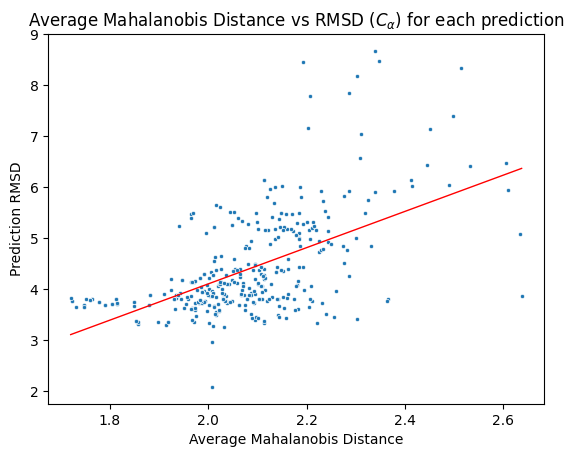

In [77]:
# Compare rmsd and mahalanobis distance
import matplotlib.pyplot as plt
from scipy.stats import linregress

def plot_md_vs_rmsd(rmsd_lim=50, md_lim=10):
    results['Model'] = results['Model'].apply(lambda x: x.split('-')[0])
    group_maha = phi_psi_predictions.groupby(['protein_id'], as_index=False).mean(numeric_only=True)#.sort_values('mahalanobis_dist').set_index('protein_id').dropna()
    group_maha = group_maha.merge(results[['Model', 'RMS_CA']], left_on='protein_id', right_on='Model', how='inner')
    group_maha = group_maha[(group_maha.RMS_CA < rmsd_lim) * (group_maha.md < md_lim)].dropna()
    fig, ax = plt.subplots()
    sns.scatterplot(data=group_maha, x='md', y='RMS_CA', ax=ax, marker='.', legend=False)
    sns.regplot(data=group_maha, x='md', y='RMS_CA', ax=ax, ci=False, scatter=False, color='red', line_kws={'lw':1}, label='Regression Line')
    ax.set_xlabel('Average Mahalanobis Distance')
    ax.set_ylabel('Prediction RMSD')
    ax.set_title(r'Average Mahalanobis Distance vs RMSD ($C_{\alpha}$) for each prediction')
    regr = linregress(group_maha.md, group_maha.RMS_CA)
    print(f"R-squared: {regr.rvalue**2:.6f}")
plot_md_vs_rmsd(9, 2.75)
# ax.set_xlim((0.8,1.4))
# ax.set_ylim((0,6))

# Specific Cases

(40490, 7)
(25922, 7)
(29711, 7)
(14531, 7)


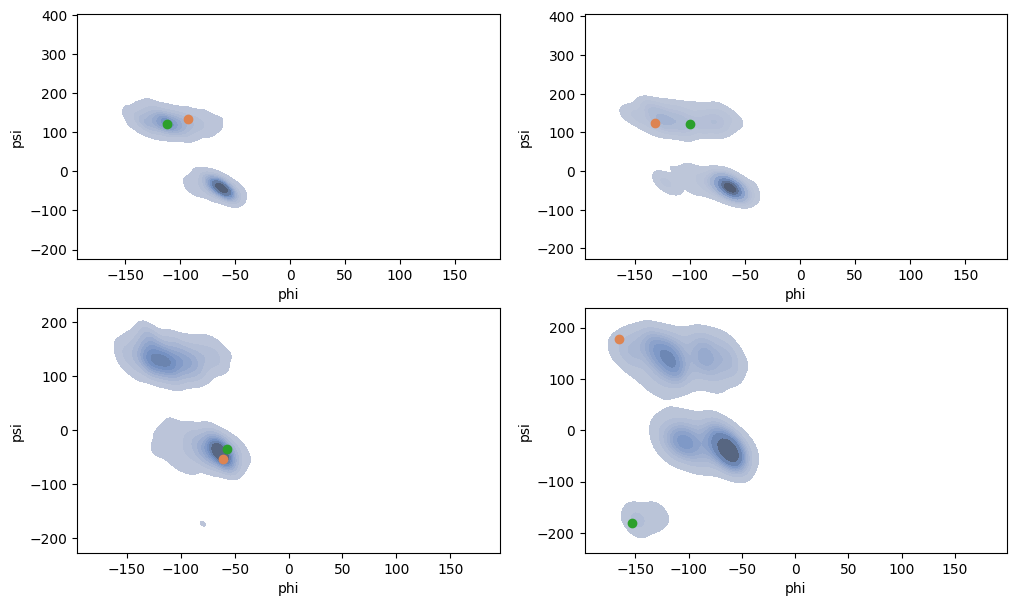

In [143]:
# plot dists with highest mahalanobis distance for alphafold
phi_psi_alpha = phi_psi_predictions[phi_psi_predictions.protein_id == alphafold_id]
seqs_with_highest_maha = phi_psi_alpha.sort_values('md', ascending=False).head(16).seq.values
m = 0
fig, axes = plt.subplots(2,2,figsize=(12,7))
for i,seq in enumerate(seqs_with_highest_maha[m:m+4]):
    xray_phi_psi_seq = xray_phi_psi[xray_phi_psi.seq == seq]
    phi_psi_dist = phi_psi_mined[phi_psi_mined.seq == seq]
    print(phi_psi_dist.shape)
    phi_psi_alpha_seq = phi_psi_alpha[phi_psi_alpha.seq == seq]
    ax = axes.flatten()[i]
    sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax, fill=True, color='#7490c0', legend=True)
    ax.plot(phi_psi_alpha_seq.phi, phi_psi_alpha_seq.psi, 'o', color='#dd8452', label='Prediction')
    ax.plot(xray_phi_psi_seq.phi, xray_phi_psi_seq.psi, 'o', color='tab:green', label='X-ray')

In [ ]:
# Look at predictions with very high rmsd
plot_clusters_for_window(seq, alphafold_id, 'AlphaFold', eps=10, axlims=((-180, -10), (-100, 200)))
plot_res_vs_md(alphafold_id, pred_name="AlphaFold")

In [ ]:
# Look at spots of a prediction where md_pred >> md_xray
phi_psi_alpha = phi_psi_predictions[phi_psi_predictions.protein_id == alphafold_id]
phi_psi_alpha['md_diff'] = phi_psi_alpha['md'] - phi_psi_alpha['md_xray']
seqs_with_highest_diff = phi_psi_alpha.sort_values('md_diff', ascending=False).head(16).seq.values
seqs_with_highest_diff